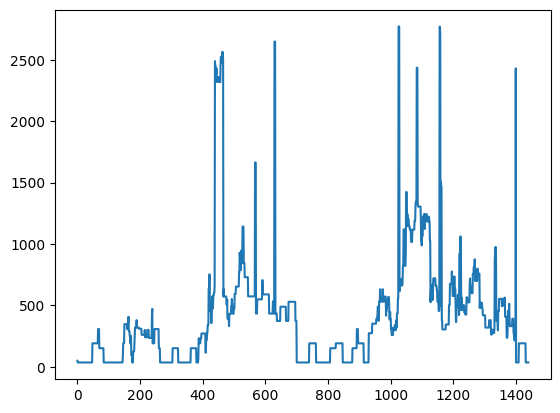

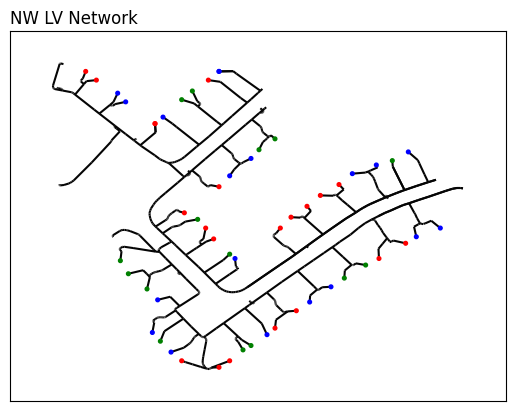

/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


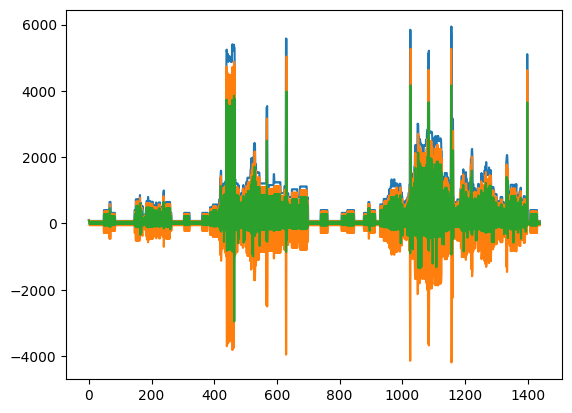

In [1]:
import numpy as np
import csv
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates
import builtins
import os

#Constants 
Sbase=100; #MVA
Vbase=240.177; #kV

Zbase=(Vbase**2)/Sbase
phases = 3
PF = 0.95
slackBus = 0

with builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/LineCodes.csv', newline='') as linecodefile, builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Lines.csv', newline='') as linesfile, builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Loads.csv') as loadsfile, builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Load_profile_1.csv') as profilefile, builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Buscoords.csv') as busfile:
    lines_code = np.array(list(csv.reader(linecodefile)), dtype=object)
    lines_data = np.array(list(csv.reader(linesfile)), dtype=object)
    loads_data = np.array(list(csv.reader(loadsfile)), dtype=object)
    load_profile = np.array(list(csv.reader(profilefile)), dtype=object)
    bus_coords = np.array(list(csv.reader(busfile)), dtype=object)

def data_cleaning(load_profile, lines_data, lines_code):
    load_profile = load_profile[:,1] #Remove timestamp column
    #Initiate arrays for admitance calculation
    resistance_Rs = ['resistance_Rs']
    resistance_Rm = ['resistance_Rm']
    reactance_Xs = ['reactance_Xs']
    reactance_Xm = ['reactance_Xm']
    impedance_Zs = ['impedance_Zs']
    impedance_Zm = ['impedance_Zm']
    #Find in line code data the specific resitance and reactance for each line
    for i in range(len(lines_data)):
        if i != 0:
            resistance_Rs = np.append(resistance_Rs, lines_code[np.where(lines_data[i,6] == lines_code[:,0])[0][0], 2])
            resistance_Rm = np.append(resistance_Rm, lines_code[np.where(lines_data[i,6] == lines_code[:,0])[0][0], 4])
            reactance_Xs = np.append(reactance_Xs, lines_code[np.where(lines_data[i,6] == lines_code[:,0])[0][0], 3])
            reactance_Xm = np.append(reactance_Xm, lines_code[np.where(lines_data[i,6] == lines_code[:,0])[0][0], 5])
    
    #Append the resistance and reactance to the array and convert data to complex
    lines_data = np.append(lines_data, resistance_Rs.reshape(906,1), axis=1)
    lines_data = np.append(lines_data, reactance_Xs.reshape(906,1), axis=1)
    lines_data = np.append(lines_data, resistance_Rm.reshape(906,1), axis=1)
    lines_data = np.append(lines_data, reactance_Xm.reshape(906,1), axis=1)
    lines_data[1:,7] = lines_data[1:,7].astype(complex)
    lines_data[1:,8] = lines_data[1:,8].astype(complex)
    lines_data[1:,9] = lines_data[1:,9].astype(complex)
    lines_data[1:,10] = lines_data[1:,10].astype(complex)
    lines_data[1:,4] = lines_data[1:,4].astype(float)
    lines_data[1:,1] = lines_data[1:,1].astype(int)
    lines_data[1:,2] = lines_data[1:,2].astype(int)

    #Calculate impedances of the lines columns are hardcoded in relation to the previous order of appended columns (Rm, Rx, Xs, Xm)
    for i in range(len(lines_data)):
        if i !=0:
            impedance_Zs = np.append(impedance_Zs,((2*lines_data[i,7] + lines_data[i,9])/3)*(lines_data[i,4]/1000) + 1j*((2*lines_data[i,8] + lines_data[i,10])/3)*(lines_data[i,4]/1000))
            impedance_Zm = np.append(impedance_Zm,((2*lines_data[i,9] - lines_data[i,7])/3)*(lines_data[i,4]/1000) + 1j*((2*lines_data[i,10] - lines_data[i,8])/3)*(lines_data[i,4]/1000))
    #Append impedances to data array 
    lines_data = np.append(lines_data, impedance_Zs.reshape(906,1), axis=1)
    lines_data = np.append(lines_data, impedance_Zm.reshape(906,1), axis=1)
    return lines_data, load_profile

def end_nodes(lines_data):
    #--------- Backward ordered nodes and lines -----#
    endNodes = []
    backOrderedNodes = []
    backOrderedLine = []
    nodeA = lines_data[1:,1].astype(int)
    nodeB = lines_data[1:,2].astype(int)
    
    #Create array with ordered lines
    lines_data = np.append(lines_data, lines_data[:,0].reshape(906,1), axis=1)
    lines_data[:,13] = np.char.replace(lines_data[:,13].astype(str), "LINE", "")
    ordered_lines = np.sort(lines_data[1:,13].astype(int))

    while len(backOrderedNodes) < len(lines_data)-1:
        endNodes = np.setdiff1d(nodeB, nodeA)
        backOrderedNodes = np.append(backOrderedNodes, endNodes)
        idx = np.intersect1d(nodeB, endNodes, return_indices=True)[1]
        for i in range(len(idx)):
            backOrderedLine = np.append(backOrderedLine, ordered_lines[idx[i]])
            nodeA[idx[i]]= 0
            nodeB[idx[i]]= 0

    #--------- Forward ordered lines -----#
    backOrderedNodes = np.append(backOrderedNodes, 1)
    forwardOrderedLine = np.flip(backOrderedLine)
    return backOrderedNodes, forwardOrderedLine, ordered_lines, lines_data

def initial_values(loads_data, load_profile, bus_coords):
    #Create array with real and reactive power for each bus with 3 phases
    Pi = np.zeros((len(bus_coords)-1, phases, len(load_profile)-1))
    for i in range(len(loads_data)):
            if i != 0:
                bus = int(loads_data[i,2])
                bus_phase = loads_data[i,3]
                if bus_phase == 'A': bus_phase = 0
                if bus_phase == 'B': bus_phase = 1
                if bus_phase == 'C': bus_phase = 2
                Pi[bus-1,bus_phase,:] = load_profile[1:]
    #Convert power to Watts instead of kW. 
    Pi = Pi*100

    #Create an same size array as apparent power for reactive power 
    Qi = np.zeros((len(bus_coords)-1, phases, len(load_profile)-1))
    #Apply power factor to determine reactive power
    Qi = (Pi/0.95) * np.sin(np.arccos(PF))

    calcNodeVoltages = np.zeros((len(bus_coords)-1, phases, 1440), dtype=complex)
    calcLineCurrents = np.zeros((len(lines_data)-1, phases, 1440), dtype=complex)
    Tload = np.zeros((1440,3), dtype=complex)
    return Pi, Qi, calcLineCurrents, calcNodeVoltages, Tload

def f_b_sweep(Pi, Qi, calcLineCurrents, calcNodeVoltages, Tload, backOrderedNodes, forwardOrderedLine, ordered_lines, load_profile):
    for i in range(len(load_profile)-1):
        #Creating starting values for algorithm
        error = 1
        epsilon = 0.000001
        iter = 0 
        nodeVoltages = np.zeros((len(bus_coords)-1, phases, 50),dtype=complex)
        loadCurrents = np.zeros((len(bus_coords)-1, phases, 50),dtype=complex)
        lineCurrents = np.zeros((len(lines_data)-1, phases, 50),dtype=complex)
        
        if i == 0:
            nodeVoltages[:,:,iter] = np.ones((len(bus_coords)-1,3))*((1*np.exp(1j*(-2*np.pi/3))*np.exp(1j*(2*np.pi/3)))*Vbase).astype(complex)
            nodeVoltages[:,1,iter] = nodeVoltages[:,1,0]*np.exp(1j*(-2*np.pi/3))
            nodeVoltages[:,2,iter] = nodeVoltages[:,2,0]*np.exp(1j*(2*np.pi/3))
        else:
            nodeVoltages[:,:,iter] = calcNodeVoltages[:,:,i-1]
        
        while error > epsilon:
            iter = iter+1
            loadCurrents[:,:,iter] = np.conj((Pi[:,:,i]+1j*Qi[:,:,i])/nodeVoltages[:,:,iter-1]) #Calculate load current from S/V

            #----- Start backward sweep -----#
            for bsweep in range(len(backOrderedNodes)-1):
                node = int(backOrderedNodes[bsweep])
                nA_n = np.where(lines_data[1:,1].astype(int) == node)[0]
                sumCurs = np.zeros(3)
                loadCurs = np.zeros(3)
                outCurrents = np.zeros(3)
                if np.size(nA_n) != 0:
                    for b in range(len(nA_n)):
                        outCurrents = outCurrents + lineCurrents[nA_n[b], :, iter]
                else:
                    outCurrents = np.zeros(3)

                nB_n = np.where(lines_data[1:,2].astype(int) == node)[0][0]
                loadCurs = loadCurrents[node-1,:,iter]
                sumCurs = loadCurs + outCurrents
                lineCurrents[nB_n,:,iter] = sumCurs

            #----- Start forward sweep -----#
            #----- Assume transformer voltage is fixed (Slack bus)
            nodeVoltages[slackBus,:,iter] = np.ones(3)*((1*np.exp(1j*(-2*np.pi/3))*np.exp(1j*(2*np.pi/3)))*Vbase) 
            nodeVoltages[slackBus,1,iter] = nodeVoltages[slackBus,1,0]*np.exp(1j*(-2*np.pi/3))
            nodeVoltages[slackBus,2,iter] = nodeVoltages[slackBus,2,0]*np.exp(1j*(2*np.pi/3))
            nodeA_list = lines_data[1:,1].astype(int)
            nodeB_list = lines_data[1:,2].astype(int)
            for fsweep in range(len(forwardOrderedLine)):
                lineNum = int(forwardOrderedLine[fsweep])
                lineIn = np.where(ordered_lines == lineNum)[0][0]
                nodeA = nodeA_list[lineIn]
                nodeB = nodeB_list[lineIn]
                VA = nodeVoltages[np.where(bus_coords[1:,0].astype(int) == nodeA)[0][0],:,iter]
                Il = np.matrix(lineCurrents[lineIn,:,iter])
                
                Zs = lines_data[lineIn+1,11]
                Zm = lines_data[lineIn+1,12]

                Z_matrix = np.matrix(np.array([[Zs, Zm, Zm],[Zm, Zs, Zm],[Zm, Zm,Zs]], dtype=complex))
                VB = VA - (Il*Z_matrix)
                nodeVoltages[np.where(bus_coords[1:,0].astype(int) == nodeB)[0],:,iter] = VB.astype(complex)
            
            #----- CHECK FOR CONVERGENCE -----#
            error = 0
            error = np.real(((nodeVoltages[:,:,iter] - nodeVoltages[:,:,iter-1])).max())
            
        calcLineCurrents[:,:,i] = lineCurrents[:,:,iter].astype(complex)
        calcNodeVoltages[:,:,i] = nodeVoltages[:,:,iter].astype(complex)
        Tload[i,:] = calcNodeVoltages[1,:,i]*calcLineCurrents[1,:,i]
        # print(Tload[i,:])
    return Tload, calcNodeVoltages, calcLineCurrents

def plot_network():
    lv_Network = nx.Graph()
    bus_coords[1:,0] = bus_coords[1:,0].astype(int)
    bus_coords[1:,1] = bus_coords[1:,1].astype(float)
    bus_coords[1:,2] = bus_coords[1:,2].astype(float)
    loads_data[1:, 2] = loads_data[1:, 2].astype(int)

    #Make all buses nodes in the network
    for i in range(len(bus_coords)-1):
        x = bus_coords[i+1,1]
        y = bus_coords[i+1,2]
        lv_Network.add_node(bus_coords[i+1,0], pos=[x, y])

    #Create house load nodes
    bus_colors = []
    for i in range(len(loads_data)-1):
        bus_phase = loads_data[i+1,3]
        if bus_phase == 'A': bus_phase = "red"
        if bus_phase == 'B': bus_phase = "blue"
        if bus_phase == 'C': bus_phase = "green"
        bus_colors = np.append(bus_colors, bus_phase)
        x = np.where(bus_coords[1:,1]==loads_data[i+1, 2])
        y = np.where(bus_coords[1:,2]==loads_data[i+1, 2])
        lv_Network.add_node(loads_data[i+1, 0], pos=[x, y])

    #Add edges to the nodes
    for i in range(len(lines_data)-1):
        lv_Network.add_edge(lines_data[i+1, 1], lines_data[i+1, 2], length=lines_data[i+1, 4])

    nx.draw_networkx_edges(lv_Network, nx.get_node_attributes(lv_Network, 'pos'), width=1.5, edge_color='#050505')
    nx.draw_networkx_nodes(lv_Network, nx.get_node_attributes(lv_Network, 'pos'), nodelist=loads_data[1:, 2], node_color=bus_colors, node_size=7 )
    plt.title('NW LV Network', loc='left')
    plt.show()

load = load_profile[1:,1].astype(float)*1000
hour = np.arange(0,1440,1)
plt.plot(hour,load)
plt.show()
lines_data, load_profile = data_cleaning(load_profile, lines_data, lines_code)
backOrderedNodes, forwardOrderedLine, ordered_lines, lines_data = end_nodes(lines_data)
Pi, Qi, calcLineCurrents, calcNodeVoltages, Tload = initial_values(loads_data, load_profile, bus_coords)
plot_network()

#Now do the f-b-sweep with all the data calculated
Tload, calcNodeVoltages, calcLineCurrents = f_b_sweep(Pi, Qi, calcLineCurrents, calcNodeVoltages, Tload, backOrderedNodes, forwardOrderedLine, ordered_lines, load_profile)

plt.plot(hour, Tload)
plt.show()

Pout_A = np.real(Tload[:,0])
Qout_A = np.imag(Tload[:,0])
Pout_B = np.real(Tload[:,1])
Qout_B = np.imag(Tload[:,1])
Pout_C = np.real(Tload[:,2])
Qout_B = np.imag(Tload[:,2])

In [2]:
np.where(load_profile[1:].astype(float)==load_profile[1:].astype(float).max())

(array([1025, 1026, 1027]),)

In [3]:
list = loads_data[1:,2].astype(int)
list

array([ 34,  47,  70,  73,  74,  83, 178, 208, 225, 248, 249, 264, 276,
       289, 314, 320, 327, 337, 342, 349, 387, 388, 406, 458, 502, 522,
       539, 556, 562, 563, 611, 614, 619, 629, 639, 676, 682, 688, 701,
       702, 755, 778, 780, 785, 813, 817, 835, 860, 861, 886, 896, 898,
       899, 900, 906])

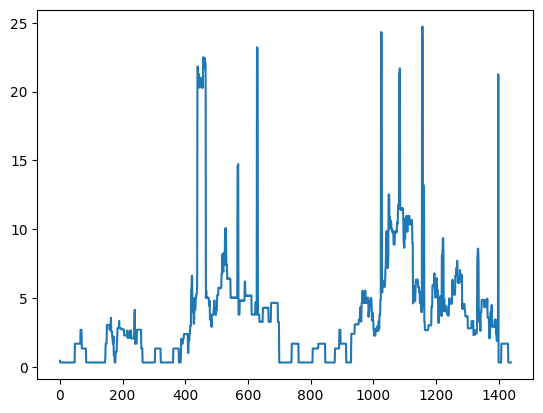

In [4]:
plt.plot(calcLineCurrents[0,0])

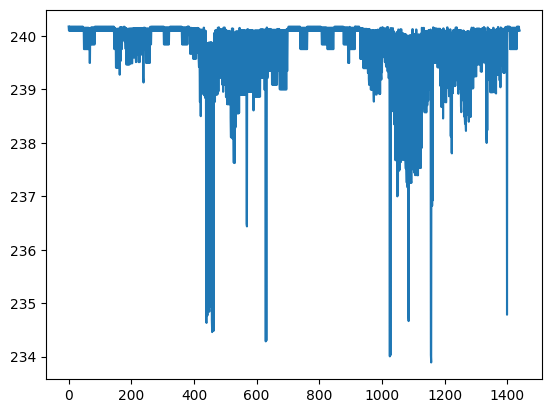

In [40]:
plt.plot(np.real(calcNodeVoltages[900,0,:]))

(240.1761930706127+0.0009441646865634516j)

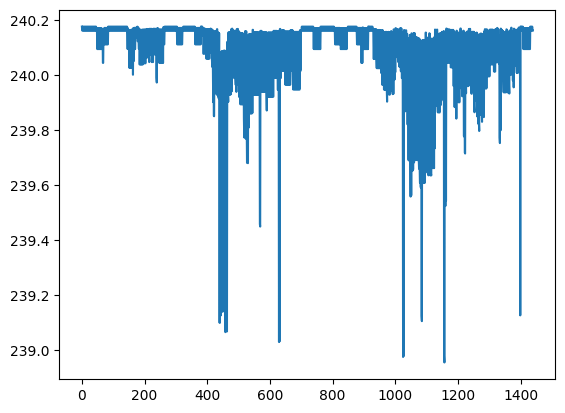

In [42]:
plt.plot(np.real(calcNodeVoltages[34,0,:]))
calcNodeVoltages[34,0,:].max()
calcNodeVoltages[34,0,:].min()

In [15]:
import pandas as pd

date_period = '2022-01-01/2022-01-02'
with builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Load_profile_1.csv', newline='') as loadprofile_file, builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/pv_generation_data/pv_profiles/profile_year.csv', newline='') as pvprofile_file:
    pv_profile = pd.read_csv(pvprofile_file)
    range_days = date_period.split('/')
    mask = (pv_profile['index_date'] >= range_days[0]) & (pv_profile['index_date'] <= range_days[1])
    pv_profile = pv_profile[mask]
    
    # load_profile = pd.read_csv(loadprofile_file)
    # load_profile['mult'] = load_profile['mult']*1000

In [20]:
(load_profile[1:].astype(float) - pv_profile['P']).max()

2.771

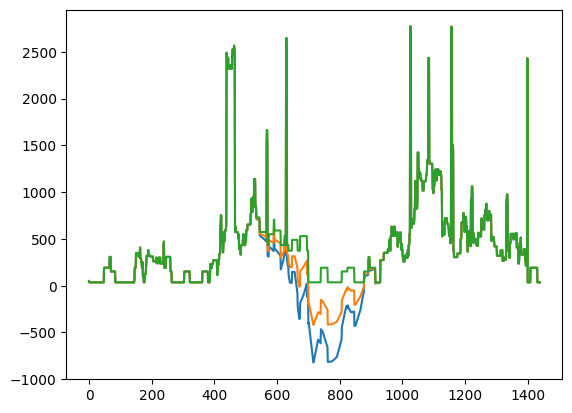

In [29]:
plt.plot(load_profile[1:].astype(float)*1000 - pv_profile['P_CFPV'])
plt.plot(load_profile[1:].astype(float)*1000 - pv_profile['P'])
plt.plot(load_profile[1:].astype(float)*1000)

In [30]:
import pandas as pd

date_period = '2022-07-01/2022-07-02'
with builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Load_profile_1.csv', newline='') as loadprofile_file, builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/pv_generation_data/pv_profiles/profile_year.csv', newline='') as pvprofile_file:
    pv_profile = pd.read_csv(pvprofile_file)
    range_days = date_period.split('/')
    mask = (pv_profile['index_date'] >= range_days[0]) & (pv_profile['index_date'] <= range_days[1])
    pv_profile = pv_profile[mask]
    
    # load_profile = pd.read_csv(loadprofile_file)
    # load_profile['mult'] = load_profile['mult']*1000

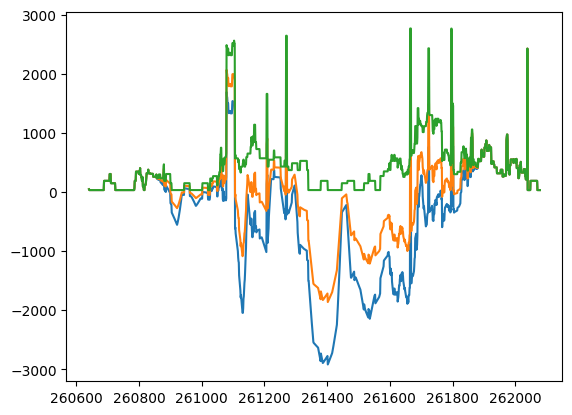

In [39]:
# plt.plot(load_profile[1:].astype(float)*1000)
plt.plot(load_profile[1:].astype(float)*1000 - pv_profile['P_CFPV'])
plt.plot(load_profile[1:].astype(float)*1000 - pv_profile['P'])
plt.plot(load_profile[1:].astype(float)*1000 - pv_profile['P'] + pv_profile['P'])
